In [76]:
import numpy as np
import sklearn
import skimage
import cv2
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics.pairwise import rbf_kernel

import warnings
warnings.filterwarnings('ignore')

# 📊 Histogramme de gradient orienté 📈

Une présentation d'Alix ANNERAUD, Capucine GARREAU, Aliénor TRANOUEZ et Zya PEUDEVIN.

# 🚀 Introduction 

Le **traitement d'images** est un domaine essentiel en informatique.

Ses objectifs : 
-  analyser
-  interpréter
-  transformer 

La **détection de caractéristiques** est étape cruciale pour extraire des informations pertinentes.

Permet : 
-  la reconnaissance d'objets 
-  la détection de mouvements
-  analyse de scènes

**Histogrammes de gradients orientés (HOG)** est une des méthodes les plus populaires pour **détecter** et **représenter** des caractéristiques dans les images.

## 📋 Sommaire

1. 🏺 Histoire
2. 📚 Fondements théoriques
3. 🛠️ Applications
4. 🔍 Étude de cas
5. 📊 Analyse

# 2. 🏺 Histoire

## 📜 Contexte

Avant HOG on utilisait des transformées de Fourier, des contours de Canny ou encore des histogrammes de gradients

Mais on a besoin d'un descripteur plus **robuste** -> HOG en **2005** avec l'article: "Histograms of Oriented Gradients for Human Detection"

L'idée derrière le HOG est que la forme et la texture des objets sont capturées par la distribution des gradients locaux. Cette même idée est apparue dans un brevet de **Robert K. McConnel en 1986**: "Method and Apparatus for Partern Recognition"


## 🚀 Avancées

Le HOG peut améliorer la **détéction d'objets dans des environnements variés.**

Il offre particulièrement une **précision accrue** sur la **détéction de piétons** par rapport aux méthodes précédentes.

Les domaines de son utilisation sont la **sécurité**, la **surveillance** et les **véhicules autonomes**.

## 🌱 Adoption et évolution

HOG est devenue un **standard** parmis les descripteurs d'images.

Pour preuve il est même intégré à **OpenCV**.

C'est un outil **traditionnel** prisé car **rapide et moins gourmand en ressource**.

## 🌟 Impacts et Contributions du HOG

HOG est un **précurseur** de nombreuses techniques de **détections d'objets**.

Il a **contribué** à l'amélioration des algorithmes de **vision par ordinateur**.

Il est populaire encore aujourd'hui par sa **robustesse** et son **efficacité**.

# 3. 📚 Théorie

Nous allons maintenant vous présenter la théorie derrière l'Histogramme de gradient orienté.

## ✂️ Découpage

- Découpage en cellule

- Regroupement des cellules en blocs

## 📐 Calcul des gradients

Dans une cellule, on calcule les gradients : 

$$
G(x, y) = \begin{cases}
\frac{\partial I}{\partial x} \\
\frac{\partial I}{\partial y}
\end{cases}
$$

où $I$ est l'intensité de l'image en $(x, y)$.

In [153]:
image_astronaute = skimage.data.astronaut()

image_astronaute_gris = skimage.color.rgb2gray(image_astronaute)

gradient_astronaute = [
    cv2.Sobel(image_astronaute_gris, cv2.CV_64F, 1, 0, ksize=5),
    cv2.Sobel(image_astronaute_gris, cv2.CV_64F, 0, 1, ksize=5)
]



In [154]:
%%capture out

figure, axes = plt.subplots(1, 3)

axes[0].imshow(image_astronaute)
axes[0].set_title('Image originale')
axes[0].axis('off')

axes[1].imshow(gradient_astronaute[0])
axes[1].set_title('Gradient en x')
axes[1].axis('off')

axes[2].imshow(gradient_astronaute[1])
axes[2].set_title('Gradient en y')
axes[2].axis('off')

plt.show()

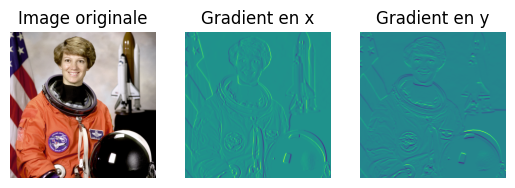

In [155]:
out()

On passe ces vecteurs de gradient en coordonnées polaires :

$$

v(x, y) = \begin{cases}
\sqrt{G_x^2 + G_y^2} \\
\arctan\left(\frac{G_y}{G_x}\right)
\end{cases}
$$

In [175]:
v = [
    np.sqrt(gradient_astronaute[0]**2 + gradient_astronaute[1]**2),
    np.arctan2(gradient_astronaute[1], gradient_astronaute[0])
]

In [176]:
%%capture out

figure, axes = plt.subplots(1, 2)

axes[0].imshow(v[0], cmap='hsv')
axes[0].set_title('Norme du gradient')
axes[0].axis('off')

axes[1].imshow(v[1], cmap='gray')
axes[1].set_title('Angle du gradient')
axes[1].axis('off')

plt.show()

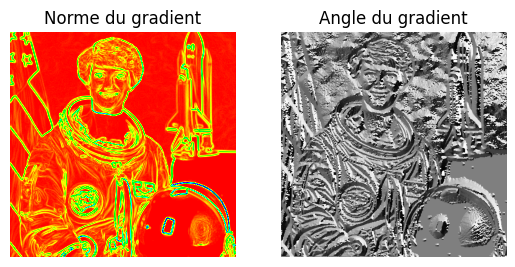

In [177]:
out()

## ⚖️ Normalisation

Les histogrammes de chaques blocs sont normalisés:

$$
v_{\text{norm}} = \frac{v}{\sqrt{\|v\|^2 + \epsilon^2}}
$$

Où : 
- $v$ est le vecteur de l'histogramme
- $\epsilon$ est un paramètre de normalisation

## 📊 Création de l'histogramme

Les histogrammes sont créés en regroupant les gradients par orientation.

## 📊 Création de l'histogramme

![](./Images/Histogramme_1.jpg)

## 📊 Création de l'histogramme

![](./Images/Histogramme_2.jpg)

## 📊 Création de l'histogramme

![](./Images/Histogramme_3.jpg)

## 📊 Création de l'histogramme

![](./Images/Histogramme_4.jpg)

## 📊 Création de l'histogramme

![](./Images/Histogramme_6.png)

## 📊 Création de l'histogramme

![](./Images/Histogramme_5.png)

In [220]:
%%capture out

hog_vecteurs,  hog_image = skimage.feature.hog(
    image_astronaute_gris,
    pixels_per_cell=(16, 16),
    cells_per_block=(2, 2),
    block_norm="L2-Hys",
    visualize=True,
)

print(hog_vecteurs.shape)

figure, axes = plt.subplots(1, 3)

axes[0].imshow(image_astronaute_gris, cmap='gray')
axes[0].set_title('Image originale')
axes[0].axis('off')

hog_image_rescaled = skimage.exposure.rescale_intensity(hog_image, in_range=(0, 10))

axes[1].imshow(hog_image_rescaled, cmap='gray')
axes[1].set_title('HOG')
axes[1].axis('off')

axes[2].hist(hog_vecteurs, bins=50)
axes[2].set_title('Histogramme des gradients')

plt.tight_layout()
plt.show()

(34596,)


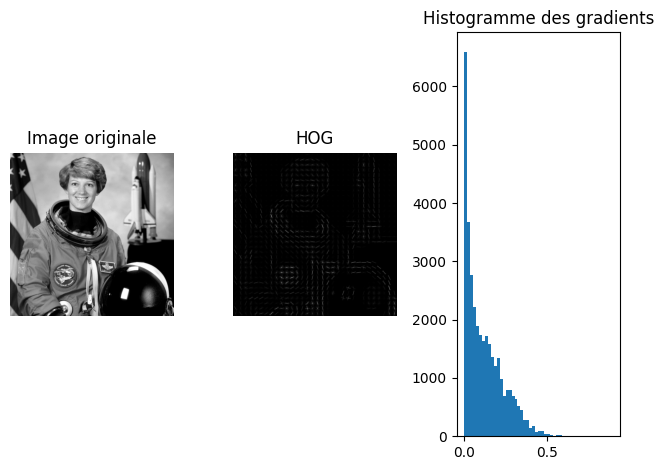

In [221]:
out()

# 4. 🛠️ Applications

Nous allons maintenant vous présenter les applications de l'Histogramme de gradient orienté.

## 📦 Détection d'objets

- Capture les caractéristiques géométriques et de texture des objets

1. HOG
2. SVM
3. Sliding window

L’une des applications les plus populaires du HOG est la détection d’objets, notamment la détection de piétons. 

En raison de sa capacité à capturer les caractéristiques géométriques et les contours des objets.La détection d’objets avec HOG repose généralement sur un classificateur de type SVM (Support VectorMachine) qui est entraîné pour différencier les caractéristiques des objets d’intérêt (par exemple, lessilhouettes de piétons) des autres formes présentes dans l’image. Le processus est le suivant :

1. Extraction des caractéristiques HOG de l’image d’entrée.
2. Application d’un modèle SVM entraîné sur des données d’objets pour détecter les zones corres-pondant aux objets.
3. Balayage de l’image à différentes échelles pour détecter les objets de différentes tailles.

Cette approche permet d’atteindre une précision élevée pour la détection de piétons, et elle estlargement utilisée dans des applications telles que la surveillance vidéo et les systèmes de conduiteassistée

## 👨‍🦰 Reconnaissance de formes et de visages

Représentation compacte des gradients

1. Extraction de la région d'intérêt
2. Calcul de HOG
3. Comparaison avec les visages déjà étiqutés

Le HOG est également couramment utilisé dans la reconnaissance de formes et de visages. Sa capacitéà représenter les gradients de manière compacte et informative en fait un choix approprié pour la détectionde caractéristiques faciales.

Dans le cas de la reconnaissance faciale, les caractéristiques HOG sont extraites de régions du visageet comparées à un ensemble de données de visages préalablement étiquetés. L’algorithme peut alorsdéterminer si un visage est présent dans l’image et identifier potentiellement des traits spécifiques, commeles yeux, le nez et la bouche. L’algorithme de détection de visage de la bibliothèque OpenCV, par exemple,utilise souvent HOG combiné avec des classificateurs en cascade pour obtenir des résultats rapides et précis.

## 🏭 Applications industrielles 

- Sécurité
- Surveillance
- Véhicules autonomes
- Robotique

Les applications industrielles du HOG sont nombreuses et incluent la sécurité, la surveillance, l’au-tomatisation et même la robotique. Voici quelques exemples notables :

- Sécurité et Surveillance: La détection de comportements suspects ou de mouvements inhabi-tuels dans des vidéos de surveillance est facilitée par le HOG, car il permet de détecter la présencehumaine même dans des environnements encombrés.7
- Automatisation des Véhicules: Dans les systèmes d’aide à la conduite (ADAS), le HOG estutilisé pour la détection de piétons et d’autres véhicules, réduisant ainsi le risque de collision.—Robotique: Les robots de service et de sécurité utilisent le HOG pour détecter et interagir avecles personnes, en assurant une navigation sécurisée et en évitant les obstacles

## 🤖 Apprentissage automatique

HOG peut être utilisé pour extraire des caractéristiques d'images (embedding) pour l'apprentissage automatique.

- SVM
- Réseaux de neurones (CNN, RNN, etc.)

L’efficacité du HOG peut être renforcée en le combinant avec des techniques d’apprentissage auto-matique, telles que les machines à vecteurs de support (SVM) et les réseaux de neurones. Dans ce cadre,le HOG est utilisé pour extraire des caractéristiques de bas niveau des images, qui sont ensuite passéesen entrée à un modèle d’apprentissage automatique pour la classification.

- HOG avec SVM: Dans cette configuration, les caractéristiques HOG extraites sont passées àun modèle SVM qui effectue la tâche de classification (par exemple, piéton/non-piéton). Cela estparticulièrement utile pour la détection d’objets où les classes sont clairement définies.
- HOG avec CNN: Bien que les réseaux de neurones convolutifs (CNN) puissent égalementapprendre des caractéristiques de bas niveau, le HOG peut être utilisé comme une étape deprétraitement, en particulier pour les systèmes où des données limitées sont disponibles. Lescaractéristiques extraites peuvent ensuite être utilisées comme entrée d’un CNN pour une meilleureprécision.

# 5. 🔍 Etude de cas

## 🖼️ Exemple d'un HOG

In [127]:
image_astronaute = skimage.data.astronaut()

vecteurs, vecteurs_image = skimage.feature.hog(
    image_astronaute,
    orientations=8,  # 8 orientations pour les gradients
    pixels_per_cell=(16, 16),  # 16x16 pixels par cellule
    cells_per_block=(2, 2),  # 2 cellules par bloc
    visualize=True,  # Générer une image des vecteurs
    channel_axis=-1,  # On prend les 3 canaux de l'image (RGB)
)

print(f"Dimension de l'image : {image_astronaute.shape}")
print(f"Dimension des vecteurs : {vecteurs.shape}")

Dimension de l'image : (512, 512, 3)
Dimension des vecteurs : (30752,)


In [128]:
%%capture out

Figures, Axes= plt.subplots(1, 2, sharex=True, sharey=True)
Axes[0].axis('off')
Axes[0].imshow(image_astronaute, cmap=plt.cm.gray)
Axes[0].set_title("Image originale")

vecteurs_image_rescaled = skimage.exposure.rescale_intensity(vecteurs_image, in_range=(0, 10))

Axes[1].axis('off')
Axes[1].imshow(vecteurs_image_rescaled, cmap=plt.cm.gray)
Axes[1].set_title('Vecteurs HOG')
plt.show()

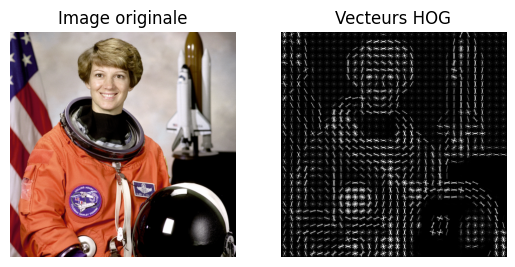

In [129]:
out()

## 👨 Reconnaissance faciale

In [80]:
def charger_images(path_base, taille=(192, 128), sort=True):
    """ Chargement des données provenant d'un même dossier, étant nommées dans le format "image_0XXX """

    # On construit un array vide qui contiendra les images 
    images = {}

    # On parcourt les fichiers du dossier
    for fichier in os.listdir(path_base):
        if fichier.endswith(".jpg"):
            chemin = os.path.join(path_base, fichier)

            # On charge l'image en RGB
            image = cv2.imread(chemin)

            # On redimensionne l'image
            if taille is not None:
                image = cv2.resize(image, taille, interpolation=cv2.INTER_CUBIC)[..., ::-1]
                
            # On stocke l'image dans le dictionnaire
            images[fichier] = image

    # On trie les images par ordre alphabétique
    if sort:
        images = dict(sorted(images.items()))

    images = list(images.values())

    return images

def obtenir_etiquettes_personnes():
    """ On labellise à la main les images : chaque personne différente a sa propre classe. """

    étiquettes = np.zeros(435, dtype=np.uint8)
    étiquettes[0:22] = 0
    étiquettes[22:41] = 1
    étiquettes[41:46] = 2
    étiquettes[46:68] = 3
    étiquettes[68:89] = 4
    étiquettes[89:112] = 5
    étiquettes[112:132] = 6
    étiquettes[132:137] = 7
    étiquettes[137:158] = 8
    étiquettes[158:163] = 9
    étiquettes[163:168] = 10
    étiquettes[168:173] = 11
    étiquettes[173:193] = 12
    étiquettes[193:214] = 13
    étiquettes[214:239] = 14
    étiquettes[239:261] = 15
    étiquettes[261:266] = 16
    étiquettes[266:285] = 17
    étiquettes[285:305] = 18
    étiquettes[305:325] = 19
    étiquettes[325:345] = 20
    étiquettes[345:365] = 21
    étiquettes[365:387] = 22
    étiquettes[387] = 23
    étiquettes[388] = 24 
    étiquettes[389] = 25
    étiquettes[390] = 26
    étiquettes[391] =  27
    étiquettes[392:397] = 28
    étiquettes[397:417] = 29
    étiquettes[417:] = 30
    
    return étiquettes

def obtenir_etiquette_genre():
    étiquettes = np.zeros(435, dtype=int)
    étiquettes[0:22] = 0
    étiquettes[22:41] = 0  
    étiquettes[41:46] = 0
    étiquettes[46:68] = 0
    étiquettes[68:89] = 1
    étiquettes[89:112] = 0
    étiquettes[112:132] = 1
    étiquettes[132:137] = 0
    étiquettes[137:158] = 0
    étiquettes[158:163] = 0
    étiquettes[163:168] = 1
    étiquettes[168:173] = 1
    étiquettes[173:193] = 1
    étiquettes[193:214] = 0
    étiquettes[214:239] = 0
    étiquettes[239:261] = 0
    étiquettes[261:266] = 0
    étiquettes[266:285] = 1
    étiquettes[285:305] = 0
    étiquettes[305:325] = 0
    étiquettes[325:345] = 1
    étiquettes[345:365] = 1
    étiquettes[365:387] = 0
    étiquettes[387] = 1
    étiquettes[388] = 0
    étiquettes[389] = 0
    étiquettes[390] = 0
    étiquettes[391] = 0
    étiquettes[392:397] = 0
    étiquettes[397:417] = 1
    étiquettes[417:] = 1

    return étiquettes

In [81]:
images_personnes = charger_images("Faces/")

étiquettes_personnes = obtenir_etiquettes_personnes()
étiquettes_genre = obtenir_etiquette_genre()

In [82]:
%%capture out

random = np.random.randint(0, high=len(images_personnes), size=4)
Axes, Figures = plt.subplots(1, 4, figsize=(20, 20))

for i in range(4):
    j = random[i]

    Figures[i].imshow(images_personnes[j], cmap='gray')
    Figures[i].axis('off')

    Genre = ["♂️", "♀️"][étiquettes_genre[j]]

    Figures[i].set_title(f"Image {j} - Sujet {étiquettes_personnes[j]} - {Genre}")

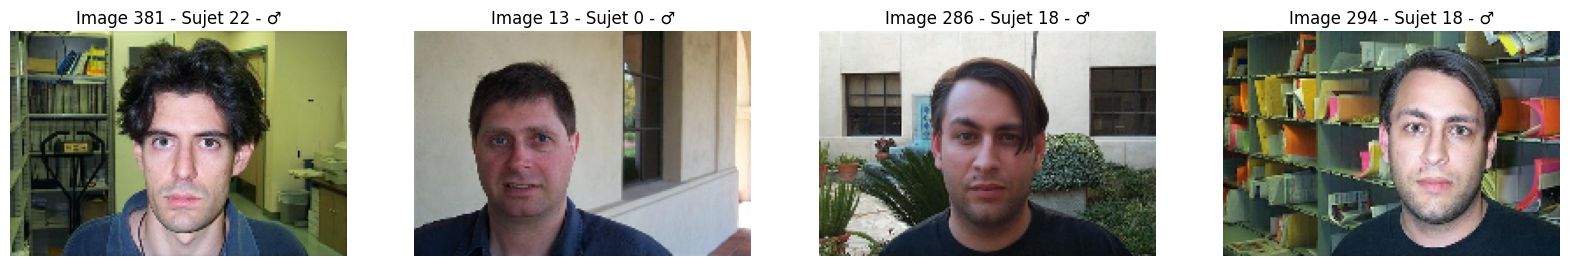

In [83]:
out()

### ➡️ Vecteurs HOG

In [84]:
def calculer_vecteurs_hog(images):
    vecteurs = []

    # On calcule le vecteur HOG pour chaque image
    for image in images:
        vecteur = skimage.feature.hog(
            image,  # Image d'entrée
            orientations=8,  # Nombre de bins
            pixels_per_cell=(8, 8),  # Taille de la cellule
            cells_per_block=(2, 2),  # Taille du bloc
            visualize=False,  # On ne veut pas visualiser les cellules
            block_norm="L2-Hys",  # Type de normalisation
            channel_axis=-1,  # On traite les images en couleur
            transform_sqrt=True,  # Amélioration du contraste
        )

        vecteurs.append(vecteur)

    return np.array(vecteurs)

In [85]:
vecteurs_hog_personnes = calculer_vecteurs_hog(images_personnes)

### 🤖 Machine à vecteurs de support

In [86]:
hyperparamètres = {
    "C": np.logspace(0, 4, 10),  # 10 valeurs de C entre 1 et 10000
    "gamma": np.logspace(-4, 0, 10),  # 10 valeurs de gamma entre 0.0001 et 1
}

# Recherche des meilleurs hyperparamètres avec une validation croisée
recherche = GridSearchCV(
    SVC(kernel=rbf_kernel),  # SVM avec noyau RBF
    hyperparamètres,  # Hyperparamètres à tester
    refit=True,  # On ré-entraîne le modèle avec les meilleurs hyperparamètres trouvés
    cv=5,  # 5 folds pour la validation croisée
    n_jobs=-1,  # Utilisation de tous les coeurs disponibles
    scoring="accuracy",  # Métrique de performance : taux de bonne classification
)
recherche.fit(vecteurs_hog_personnes, étiquettes_personnes)

print(f"Meilleurs C : {recherche.best_params_['C']}")
print(f"Meilleurs gamma : {recherche.best_params_['gamma']}")
print(f"Meilleur score : {recherche.best_score_}")

# On récupère le meilleur classificateur
meilleur_classificateur_personnes = recherche.best_estimator_

Meilleurs C : 166.81005372000593
Meilleurs gamma : 0.0001
Meilleur score : 0.5793103448275863


Le taux d'erreur est important, de 45%. Mais il faut prendre en compte que la taille de notre jeu de données (430 entrées pour 26 classes) est petite. Notre modèle réussit malgré cela à déterminer l'identité d'un sujet parmi 26 identités 55% du temps. La probabilité de choisir la bonne identité parmi 26 au hasard est de 1/26 soit environ 4%. Notre modèle a donc une performance 14 fois plus élévée que le hasard. 

### ⚡ Performances

In [109]:
# Prédictions des étiquettes
prédiction = meilleur_classificateur_personnes.predict(vecteurs_hog_personnes)

# On affiche la matrice de confusion
matrice_confusion = confusion_matrix(étiquettes_personnes, prédiction)

In [114]:
%%capture out

def afficher_matrice_confusion(matrice_confusion, ticks=None):
    plt.figure(figsize=(4, 4))
    plt.title("Matrice de confusion")
    plt.xlabel("Prédiction")
    plt.ylabel("Vérité")

    if ticks is not None:
        plt.xticks(range(len(ticks)), ticks)
        plt.yticks(range(len(ticks)), ticks)

    plt.imshow(matrice_confusion, cmap="Blues")

    for i in range(matrice_confusion.shape[0]):
        for j in range(matrice_confusion.shape[1]):
            if matrice_confusion[i, j] > 0:
                plt.text(j, i, matrice_confusion[i, j], ha="center", va="center", color="black")

    plt.colorbar()
    plt.grid(False)
    plt.show()

afficher_matrice_confusion(matrice_confusion)

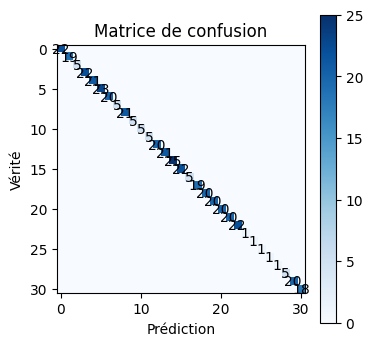

In [115]:
out()

## 🧑‍🤝‍🧑 Reconnaissance du genre

In [124]:
# Recherche des meilleurs hyperparamètres avec une validation croisée
recherche = GridSearchCV(
    SVC(kernel=rbf_kernel),  # SVM avec noyau RBF (version optimisée)
    hyperparamètres,  # Hyperparamètres à tester
    refit=True,  # On ré-entraîne le modèle avec les meilleurs hyperparamètres trouvés
    cv=5,  # 5 folds pour la validation croisée
    n_jobs=-1,  # Utilisation de tous les coeurs disponibles
    scoring="accuracy",  # Métrique de performance : taux de bonne classification
)
recherche.fit(vecteurs_hog_personnes, étiquettes_genre)

print(f"Meilleurs C : { recherche.best_params_['C']}")
print(f"Meilleurs gamma : { recherche.best_params_['gamma']}")
print(f"Meilleur score : {recherche.best_score_}")

# On récupère le meilleur classificateur
meilleur_classificateur_genre = recherche.best_estimator_

Meilleurs C : 59.94842503189409
Meilleurs gamma : 0.0001
Meilleur score : 0.7678160919540229


On observe que l'erreur de test de nos premiers entraînements pour l'identification du sexe d'un individu est plus élévé que l'erreur de validation : c'est un cas de surapprentissage (ou overfitting). Cela peut être dû à un jeu d'apprentissage trop grand par rapport aux données de validation et de test. 

Ce surapprrentissage n'est cependant pas étonnant avec nos données, en dépit de valeur classiques de séparation du jeu de données (en 0.7/0.15/0.15 puis 0.6/0.2/0.2 respectivement pour apprentissage/validation/test), car en effet plusieurs photos d'une même personne représentant la même classe crée une redondance trop importante dans l'information. 

On tente donc de réduire la taille de l'ensemble d'apprentissage, avec la séparation 0.5/0.25/0.25. 

Le taux d'erreur de test a bien diminué, et l'on a plus d'overfitting. Un taux d'erreur de 20% n'est pas utilisable pour une application directe, mais en aggrégant plus de données, ou en apprenant des hyperparamètres supplémentaires (comme la taille de la fenêtre dans HOG par exemple). 

Sachant que l'on a 2 classes, donc que la probabilité de bien classifier une image au hasard est de 1/2, notre modèle est 1.5 fois plus performant que le hasard. 

### ⚡ Performances

In [118]:
# On prédit les étiquettes des images
prediction = meilleur_classificateur_genre.predict(vecteurs_hog_personnes)

# On affiche la matrice de confusion
matrice_confusion = sklearn.metrics.confusion_matrix(étiquettes_genre, prediction)

In [119]:
%%capture out

afficher_matrice_confusion(matrice_confusion, ["♂️", "♀️"])

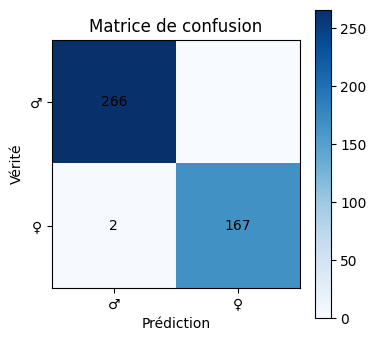

In [120]:
out()

In [94]:
erreurs = np.where(étiquettes_genre != prediction)[0]

In [95]:
%%capture out

Axes, Figures = plt.subplots(1, len(erreurs))

for i, erreur in enumerate(erreurs):
    Figures[i].imshow(images_personnes[erreur], cmap='gray')
    Figures[i].axis('off')

    Genre_réel = ["♂️", "♀️"][étiquettes_genre[erreur]]
    Genre_prédit = ["♂️", "♀️"][prediction[erreur]]

    Figures[i].set_title(f"Etiquette : {Genre_réel} - Prédiction : {Genre_prédit}")

plt.tight_layout()
plt.show()

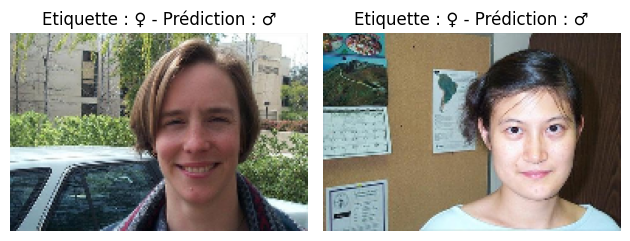

In [96]:
out()

## 📦 Reconnaissance d'objets

In [97]:
def charger_images_objets(base_path, target_size=(192, 128)):

    """ Chargement des données provenant d'un dossier contenant lui-même des sous-dossiers. 
        Chaque sous-dossier correspond à une classe d'image.
    """

    images = []
    labels = []

    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)

        if os.path.isdir(folder_path):
            label = folder_name.removeprefix(base_path)

            for filename in os.listdir(folder_path):
                image_path = os.path.join(folder_path, filename)
                image = cv2.imread(image_path)
                
                if target_size is not None:
                    #Chaque image est redimensionnée de sorte que ses 2 dimensions soient des multples de 8
                    image = cv2.resize(image, target_size, interpolation=cv2.INTER_CUBIC)

                images.append(image)

                labels.append(label)
              
    label_encoder = LabelEncoder()

    images = np.array(images)

    labels = label_encoder.fit_transform(labels)

    return images, labels, label_encoder

In [98]:
images_objets, labels_objets, label_encoder = charger_images_objets("./dataset")

print(f"Nombre d'images : {images_objets.shape}")


Nombre d'images : (1002, 128, 192, 3)


In [99]:
%%capture out

random = np.random.randint(0, high=len(images_objets), size=4)
Axes, Figures = plt.subplots(1, 4, figsize=(20, 20))

for i in range(4):
    j = random[i]

    Figures[i].imshow(images_objets[j])
    Figures[i].axis('off')

    label = labels_objets[j]

    label_string = label_encoder.inverse_transform([label])[0]

    Figures[i].set_title(f"Image {j} - {label_string}")

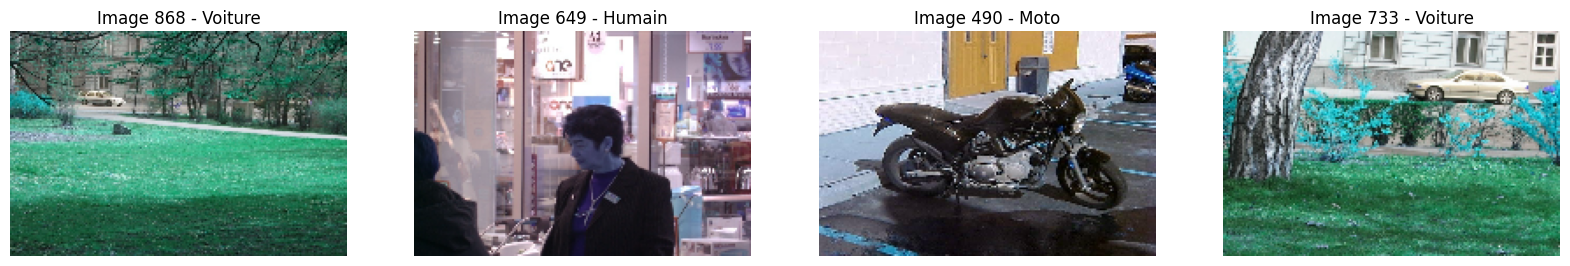

In [100]:
out()

## ➡️ Vecteurs HOG

In [101]:
vecteurs_hog_objets = calculer_vecteurs_hog(images_objets)

print(f"Dimension des vecteurs HOG : {vecteurs_hog_objets.shape}")

Dimension des vecteurs HOG : (1002, 11040)


### 🤖 Machine à vecteurs de support

In [102]:
# Recherche des meilleurs hyperparamètres avec une validation croisée
recherche = GridSearchCV(
    SVC(kernel=rbf_kernel),  # SVM avec noyau RBF
    hyperparamètres,  # Hyperparamètres à tester
    refit=True,  # On ré-entraîne le modèle avec les meilleurs hyperparamètres trouvés
    cv=5,  # 5 folds pour la validation croisée
    n_jobs=-1,  # Utilisation de tous les coeurs disponibles
    scoring="accuracy",  # Métrique de performance : taux de bonne classification
)
recherche.fit(vecteurs_hog_objets, labels_objets)

print(f"Meilleurs C : {recherche.best_params_['C']}")
print(f"Meilleurs gamma : {recherche.best_params_['gamma']}")
print(f"Meilleur score : {recherche.best_score_}")

# On récupère le meilleur classificateur
meilleur_classificateur_objets = recherche.best_estimator_

Meilleurs C : 59.94842503189409
Meilleurs gamma : 0.0001
Meilleur score : 0.7704825870646765


L'erreur de test est de 22% pour une classification de 4 classes, correspond à une performance 1.5 plus élevée que le hasard. 

### ⚡ Performances

In [121]:
# Prédictions des étiquettes
prédiction_objets = meilleur_classificateur_objets.predict(vecteurs_hog_objets)
# On calcule la matrice de confusion
matrice_confusion_objets = confusion_matrix(labels_objets, prédiction_objets)

In [122]:
%%capture out

afficher_matrice_confusion(matrice_confusion_objets, label_encoder.classes_)

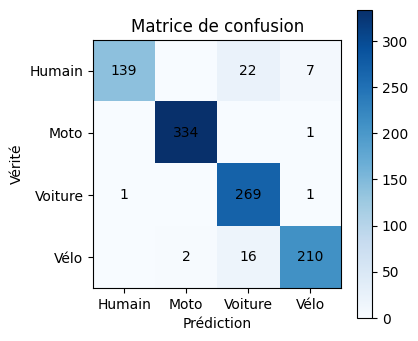

In [123]:
out()

### ✅ Conclusion 

Sur des relativement petits jeux de données, nous arrivons à créer des modèles plus performants que le hasard en couplant HOG à un SVM.

L'apprentissage de nos modèles n'est pas directement applicable à une utilisation réelle, mais montre que les méthodes de couplage de HOG, et d'apprentissage automatique sont dignes d'intérêt. 

On pourrait améliorer nos résultats en utilisant divers modèles d'apprentissage automatique, comme les CNN.

# 6. 📊 Analyse

Prenons de la distance et ajoutons du relief. Avantages, limites, concurrents et futur du HOG !

### 👍 Avantages

**Robuste aux changements d'éclairage** grâce à la nomalisation des blocs. 

**Invariant aux changements de pose** tant que les variations de pose ou d'angle de vue sont modérés.

**Facilité d'implémentation** avec sa simplicité de mise en oeuvre, il est de plus disponible dans des bibliothèques telle que OpenCV. 

**Rapidité de calcul** comparé à d'autres extracteurs de caractéristiques.

### 🛑 Limites

**Sensibilité aux changements d'échelle importants**, en effet il n'est invariant qu'à de légers changements d'échelle puisqu'il balaye l'image avec des cellules de différentes tailles mais dans une plage fixée a priori. 

**Vulnérabilité au bruit et transformations complexes** comme des variations de perspectives ou des objets particulièrement déformés.

**Moins performant pour de la détection d'objets complexes ou de haute précision** car repose sur des descripteurs bas niveau. 

### Comparaison des performances avec d'autres méthodes

### À prendre en compte avant toutes comparaisons !

HOG est principalement un **extracteur de caractéristique**, auquel on peut adjoindre différents **classificateurs**. Ici, nous le comparerons à d'autres extracteurs ainsi qu'à des **détecteurs** complets, dans ce second cas ce sera le HOG adjoint d'un SVM linéaire que l'on comparera. 

### 🔭 Autres extracteurs de caractéristiques

**SIFT (Scale-Invariant Feature Transform)** : 

✅ Invariant aux  changements d'échelle et aux rotations

❌ Plus coûteux en termes de calcul, donc moins adaptés pour du temps réel

**SURF (Speeded-Up Robust Features)** : 

✅ Version optimisée de SIFT, plus rapide 

❌ ...mais légèrement moins précis

❌ Breveté, ce qui limite son utilisation dans certaines applications commerciales. N'est plus disponible sur OpenCV

❌ Reste toujours moins rapide que HOG

**ORB (Oriented FAST and Rotated BRIEF)** : 

✅ Alternative non breveté de SURF

✅ Combine la détection rapide des caractéristiques et un descripteur BRIEF amélioré pour une invariance à la rotation

❌ Reste toujours moins rapide que HOG

### ⚡ Benchmark des méthodes 
_pour l'extraction de caractéristiques avec les méthodes HOG, SIFT et ORB d'OpenCV, sur le dataset de visages vu dans la partie application_

| Méthode | Temps moyen (s) | 
|---------|-----------------|
| HOG     | 0.0003          |
| SIFT    | 0.0026          | 
| ORB     | 0.0013          | 

### ➕ Autre détecteur d'objet

**(F)CNN ((Fully) Convolutional Neural Networks)**

_tels que YOLO (You Only Look Once) et SSD (Single Shot Detector)_

\+ Surpassent HOG pour la détection de caractéristiques complexes, meilleure précision

\- Requièrent des ressources de calcul plus élevées

\- Nécessitent des ensembles de données volumineux pour un entraînement efficace

In [106]:
import cv2
import numpy as np
import time

def benchmark_feature_detectors(images):
    results = {
        'HOG': {'time': []},
        'SIFT': {'time': [], 'keypoints': []},
        'ORB': {'time': [], 'keypoints': []}
    }
    
    # Initialisation des détecteurs
    # HOG
    hog = cv2.HOGDescriptor()
    
    # SIFT
    sift = cv2.SIFT_create()
    
    # ORB
    orb = cv2.ORB_create()
    
    # Boucle sur toutes les images
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # ---- HOG ----
        start_time = time.time()
        hog_features = hog.compute(gray)
        results['HOG']['time'].append(time.time() - start_time)
        
        # ---- SIFT ----
        start_time = time.time()
        keypoints_sift, _ = sift.detectAndCompute(gray, None)
        results['SIFT']['time'].append(time.time() - start_time)
        results['SIFT']['keypoints'].append(len(keypoints_sift))
        
        # ---- ORB ----
        start_time = time.time()
        keypoints_orb, _ = orb.detectAndCompute(gray, None)
        results['ORB']['time'].append(time.time() - start_time)
        results['ORB']['keypoints'].append(len(keypoints_orb))
    
    return results

# Exemple d'utilisation
if __name__ == "__main__":
    # Simulation d'un tableau de 435 images RGB (128, 128)
    np.random.seed(42)
    images = np.random.randint(0, 256, (435, 128, 128, 3), dtype=np.uint8)

    # Exécution du benchmark
    results = benchmark_feature_detectors(images)

    # Affichage des résultats
    for method, data in results.items():
        avg_time = np.mean(data['time'])
        if 'keypoints' in data:
            avg_keypoints = np.mean(data['keypoints'])
            print(f"{method} - Temps moyen: {avg_time:.4f}s, Points clés moyens: {avg_keypoints:.2f}")
        else:
            print(f"{method} - Temps moyen: {avg_time:.4f}s (Pas de points clés)")

HOG - Temps moyen: 0.0003s (Pas de points clés)
SIFT - Temps moyen: 0.0023s, Points clés moyens: 46.38
ORB - Temps moyen: 0.0014s, Points clés moyens: 248.57


### ❓ Que conclure de cette partie ?

HOG offre une solution **simple et efficace** pour la détection d'objets dans des scénarios simples et en **temps réel**, les **CNN** sont préférés pour des tâches nécessitant une **précision** plus élevée et une gestion de la complexité visuelle. 

Concrètement, HOG sera une bonne solution pour une implémentation en **aide à la conduite**, permettant une réponse rapide, efficace, et relativement peu coûteuse. Dans un véhicule entièrement autonome cependant, ses performances imparfaites font qu'il ne peut être la **seule** reconnaissance mise en place. Une **solution hybride**, combinant sa rapidité et l'efficacité d'une autre méthode telle que les CNN, serait nécessaire. 

Cela nous amène à la dernière sous-partie de l'analyse...

### 🛠️ Améliorations et perspectives

**Combiner avec des modèles d'apprentissage automatique** HOG peut devenir plus précis, par exemple en utilisant un SVM non-linéaire ou un CNN comme classificateur. Résultat plus **précis** qu'avec un HOG, plus **rapide** qu'avec un CNN !

$\implies$ Dans la **surveillance du traffic urbain** son utilisation en pré-traitement pour un CNN permet une accélération nécessaire de celui-ci quand les véhicules défilent à 130km/h.

**Utiliser des filtres de débruitage** tels que des filtres Gaussien permet de réduire la sensibilité au bruit du HOG.

$\implies$ Pour de la **reconnaissance faciale** on peut penser que la capacité d'adaptation du HOG à diverses luminosité en fait un bon candidat pour reconnaître le visage de l'utilisateur qui veut déverouiller son téléphone en pleine nuit, mais la très faible luminosité peut induire un bruit : l'usage d'un filtre de débruitage en amont permet de profiter des qualités du HOG dans ce domaine.

**Optimiser les paramètres pour des applications spécifiques**, en changeant la taille des cellules ou le nombre de bins dans l'histogramme par exemple, afin de s'adapter à la situation si celle-ci est connue en avance. 

$\implies$ Dans des applications très spécifiques telle que la **reconnaissance de cellules tumorales**, le fait de connaître les images types attendues permets de paramétrer aux mieux nos différentes plages et les forts changements d'échelles par exemple ne sont plus une limite. 

# ✅ Conclusion 

**HOG** pour **Histogram of Oriented Gradients**

C'est un **descripteur** clé en vision par ordinateur, reconnu pour la détection d'objets comme les piétons. 

Après avoir détaillé son fonctionnement basé sur l'analyse des gradients pour capturer les contours, nous avons examiné ses applications majeures, notamment en surveillance et en **conduite autonome**. 

Bien qu'il présente des limites face aux **changements d'échelle et au bruit**, il reste une solution **rapide et robuste**, particulièrement adaptée aux systèmes à ressources limitées. 

Son intégration avec des modèles modernes (CNN) ouvre la voie à des compromis efficaces entre **performance et complexité**.

# 👏 Fin

Merci pour votre attention ! Cette présentation est maintenant terminée.

# 📚 Références


- Wikipédia. (2024). Histogramme de gradient orienté - Wikipédia, l'encyclopédie libre. Récupéré sur [http://fr.wikipedia.org/w/index.php?title=Histogramme_de_gradient_orient%C3%A9&oldid=219342036](http://fr.wikipedia.org/w/index.php?title=Histogramme_de_gradient_orient%C3%A9&oldid=219342036) (consulté le 10/10/2024).
- Dalal, N., & Triggs, B. (2005). Histograms of oriented gradients for human detection. In *2005 IEEE Computer Society Conference on Computer Vision and Pattern Recognition (CVPR'05)* (Vol. 1, pp. 886-893). https://doi.org/10.1109/CVPR.2005.177
- Suard, F., Rakotomamonjy, A., **Bensrhair, A.**, & Broggi, A. (2006). Pedestrian Detection using Infrared images and Histograms of Oriented Gradients. In *2006 IEEE Intelligent Vehicles Symposium* (pp. 206-212). [http://www.ce.unipr.it/people/broggi/publications/iv2006-pd-aziz.pdf](http://www.ce.unipr.it/people/broggi/publications/iv2006-pd-aziz.pdf). https://doi.org/10.1109/IVS.2006.1689629
- Hafiz Ahamed, Ishraq Alam, Md. Manirul Islam (2018). In *HOG-CNN Based Real Time Face Recognition*. https://www.researchgate.net/profile/Md-Hafiz-Ahamed/publication/330684381_HOG-CNN_Based_Real_Time_Face_Recognition/links/5c531c58299bf12be3f0e777/HOG-CNN-Based-Real-Time-Face-Recognition.pdf